# 대회 개요


## 주제
- 공기압축기 이상 판단(제4회 2023 연구개발특구 AI SPARK 챌린지)
- 산업기기 피로도를 예측하는 문제

## 모델 조건
- 모델링은 비지도학습 방식으로 진행
- 입력된 데이터를 정상(0), 이상(1)로 구분하는 이진 분류 모델
- 시간 단위로 생성되는 입력 데이터에 대하여 판정을 수행할 수 있는 모델
- 신규 데이터로 학습/개선이 가능한 모델
- 외부 공공 데이터 사용 가능

## 기타 중요 내용
- 반드시 리더보드상의 순위 기록에 해당되는 버전의 코드/모델 가중치를 제출
- 소스코드 내의 모든 무작위성은 seed 설정을 통해 통제

# 데이터 불러오기

* train_data
    * 학습용 데이터 
    * 모두 정상 case로 이루어짐
    * (2463 * 8)
* test_data
    * 평가용 데이터
    * 정상 case와 이상 case가 함께 포함됨
    * (7389 * 8)

* 구성
    - air_inflow: 공기 흡입 유량 (^3/min)
    - air_end_temp: 공기 말단 온도 (°C)
    - out_pressure: 토출 압력 (Mpa)
    - motor_current: 모터 전류 (A)
    - motor_rpm: 모터 회전수 (rpm)
    - motor_temp: 모터 온도 (°C)
    - motor_vibe: 모터 진동 (mm/s)
    - type: 설비 번호
        - 설비 번호 [0, 4, 5, 6, 7]: 30HP(마력)
        - 설비 번호 1: 20HP
        - 설비 번호 2: 10HP
        - 설비 번호 3: 50HP


In [130]:
import os
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

In [131]:
train_data = pd.read_csv("https://raw.githubusercontent.com/only-juun/AI_spark_challenge/main/train_data.csv")
test_data= pd.read_csv("https://raw.githubusercontent.com/only-juun/AI_spark_challenge/main/test_data.csv")

In [132]:
drop_col = 'type'
train_data.drop(drop_col, axis=1, inplace=True)
test_data.drop(drop_col, axis=1, inplace=True)

In [133]:
train_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2463 entries, 0 to 2462
Data columns (total 7 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   air_inflow     2463 non-null   float64
 1   air_end_temp   2463 non-null   float64
 2   out_pressure   2463 non-null   float64
 3   motor_current  2463 non-null   float64
 4   motor_rpm      2463 non-null   float64
 5   motor_temp     2463 non-null   float64
 6   motor_vibe     2463 non-null   float64
dtypes: float64(7)
memory usage: 134.8 KB


# 데이터 전처리

### 새로운 Feature 추가하기

In [134]:
# 모터 전류 당 공기 유량은 압축기의 효율성
train_data['air_inflow_per_motor_current'] = train_data['air_inflow'] / train_data['motor_current']	
test_data['air_inflow_per_motor_current'] = test_data['air_inflow'] / test_data['motor_current']

# 압축기와 모터의 상태를 모두 고려한 압축기 효율1
train_data['Compressor_Efficiency1'] = train_data['out_pressure'] * train_data['air_inflow'] / train_data['motor_current'] / 3.5168
test_data['Compressor_Efficiency1'] = test_data['out_pressure'] * test_data['air_inflow'] / test_data['motor_current'] / 3.5168

# 압축기와 모터의 상태를 모두 고려한 압축기 효율2
train_data['Motor_Efficiency'] = (train_data['motor_current'] * train_data['motor_rpm']) / (746 * 1000)
test_data['Motor_Efficiency'] = (test_data['motor_current'] * test_data['motor_rpm']) / (746 * 1000)

# 압축기의 효율2
train_data['Compressor_Efficiency2'] = (train_data['out_pressure'] * train_data['air_inflow'] * (train_data['air_end_temp'] - 25)) / (train_data['motor_current'] * train_data['motor_vibe'] * 3.6)
test_data['Compressor_Efficiency2'] = (test_data['out_pressure'] * test_data['air_inflow'] * (test_data['air_end_temp'] - 25)) / (test_data['motor_current'] * test_data['motor_vibe'] * 3.6)

# 압축기의 배출량
train_data['Discharge_Volume'] = (train_data['air_inflow'] / 60) * ((train_data['air_end_temp'] + 273) / 273) * (train_data['out_pressure'] / 1.01325)
test_data['Discharge_Volume'] = (test_data['air_inflow'] / 60) * ((test_data['air_end_temp'] + 273) / 273) * (test_data['out_pressure'] / 1.01325)

# 공기의 밀도
train_data['air_density'] = train_data['out_pressure'] / (287 * (train_data['air_end_temp'] + 273))
test_data['air_density'] = test_data['out_pressure'] / (287 * (test_data['air_end_temp'] + 273))

In [135]:
df_train = train_data.copy()
df_test = test_data.copy()

# 모델링

In [6]:
import torch
import torch.nn as nn
import torch.optim as optim
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.metrics import f1_score
from sklearn.model_selection import train_test_split
import random

### seed 고정

In [7]:
def fix_seed(random_seed):
    torch.manual_seed(random_seed)
    torch.cuda.manual_seed(random_seed)
    torch.cuda.manual_seed_all(random_seed)  # if use multi-GPU
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False
    os.environ["PYTHONHASHSEED"] = str(random_seed)
    np.random.seed(random_seed)
    random.seed(random_seed)
fix_seed(42)

### 모델 정의

In [89]:
class Autoencoder(nn.Module):
    def __init__(self):
        super(Autoencoder, self).__init__()
        self.encoder = nn.Sequential(
            nn.Linear(input_dim, hidden_dim1),
            nn.Mish(),
            nn.Linear(hidden_dim1, encoding_dim),
            nn.Mish()
        )
        self.decoder = nn.Sequential(
            nn.Linear(encoding_dim, hidden_dim1),
            nn.Mish(),
            nn.Linear(hidden_dim1, input_dim),
        )

    def forward(self, x):
        x = self.encoder(x)
        x = self.decoder(x)
        return x

In [136]:
class Autoencoder(nn.Module):
    def __init__(self):
        super(Autoencoder, self).__init__()
        self.encoder = nn.Sequential(
            nn.Linear(input_dim, hidden_dim1),
            nn.Mish(),
            nn.Linear(hidden_dim1, hidden_dim2),
            nn.Mish(),
            nn.Linear(hidden_dim2, encoding_dim), # 추가된 히든 레이어
            nn.Mish() # 추가된 히든 레이어
        )
        self.decoder = nn.Sequential(
            nn.Linear(encoding_dim, hidden_dim2), # 추가된 히든 레이어
            nn.Mish(), # 추가된 히든 레이어
            nn.Linear(hidden_dim2, hidden_dim1),
            nn.Mish(),
            nn.Linear(hidden_dim1, input_dim),
        )

    def forward(self, x):
        x = self.encoder(x)
        x = self.decoder(x)
        return x

In [111]:
class Autoencoder(nn.Module):
    def __init__(self):
        super(Autoencoder, self).__init__()
        self.encoder = nn.Sequential(
            nn.Linear(input_dim, hidden_dim1),
            nn.Mish(),
            nn.Linear(hidden_dim1, hidden_dim2),
            nn.Mish(),
            nn.Linear(hidden_dim2, hidden_dim3),
            nn.Mish(),
            nn.Linear(hidden_dim3, encoding_dim), # 추가된 히든 레이어
            nn.Mish() # 추가된 히든 레이어
        )
        self.decoder = nn.Sequential(
            nn.Linear(encoding_dim, hidden_dim3), # 추가된 히든 레이어
            nn.Mish(), # 추가된 히든 레이어
            nn.Linear(hidden_dim3, hidden_dim2),
            nn.Mish(),
            nn.Linear(hidden_dim2, hidden_dim1),
            nn.Mish(),
            nn.Linear(hidden_dim1, input_dim),
        )

    def forward(self, x):
        x = self.encoder(x)
        x = self.decoder(x)
        return x

### 학습

In [137]:
# Preprocess the data
scaler = StandardScaler()
train_data_scaled = scaler.fit_transform(df_train)
test_data_scaled = scaler.transform(df_test)

In [138]:
# Convert numpy arrays to torch tensors
train_data_scaled = torch.from_numpy(train_data_scaled).float()
test_data_scaled = torch.from_numpy(test_data_scaled).float()

In [141]:
# Define the autoencoder architecture
input_dim = train_data_scaled.shape[1]
encoding_dim = 64
hidden_dim1 = 16
hidden_dim2 = 32
hidden_dim3 = 32

model = Autoencoder()

# Compile and train the autoencoder with early stopping
optimizer = torch.optim.Adam(model.parameters())
criterion = nn.MSELoss()

best_loss = float('inf')
patience = 10
count = 0

print(model)

Autoencoder(
  (encoder): Sequential(
    (0): Linear(in_features=13, out_features=16, bias=True)
    (1): Mish()
    (2): Linear(in_features=16, out_features=32, bias=True)
    (3): Mish()
    (4): Linear(in_features=32, out_features=64, bias=True)
    (5): Mish()
  )
  (decoder): Sequential(
    (0): Linear(in_features=64, out_features=32, bias=True)
    (1): Mish()
    (2): Linear(in_features=32, out_features=16, bias=True)
    (3): Mish()
    (4): Linear(in_features=16, out_features=13, bias=True)
  )
)


In [142]:
model_name = 'lastdance'

In [143]:
for epoch in range(10000):
    train_loss = 0
    for i in range(0, len(train_data_scaled), 32):
        inputs = train_data_scaled[i:i+32]
        optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs, inputs)
        train_loss += loss.item()
        loss.backward()
        optimizer.step()
    train_loss /= len(train_data_scaled)/32
    with torch.no_grad():
        val_loss = criterion(model(test_data_scaled), test_data_scaled)
        if val_loss < best_loss:
            count = 0
            best_loss = val_loss
            torch.save(model.state_dict(), f"{model_name}.pth")
        else:
            count += 1
        if count >= patience:
            print("Early stopping!")
            break
    if epoch:
        print(f"Epoch {epoch}, train loss: {train_loss}, val loss: {val_loss.item()}")

Epoch 1, train loss: 0.3971562118390881, val loss: 0.2704014480113983
Epoch 2, train loss: 0.32891805506894806, val loss: 0.25107139348983765
Epoch 3, train loss: 0.29117599948847434, val loss: 0.17527902126312256
Epoch 4, train loss: 0.17495719076316144, val loss: 0.16196630895137787
Epoch 5, train loss: 0.12000227606107779, val loss: 0.089419886469841
Epoch 6, train loss: 0.10027256108278963, val loss: 0.0694914311170578
Epoch 7, train loss: 0.08868432222248043, val loss: 0.037020113319158554
Epoch 8, train loss: 0.08159480485618961, val loss: 0.04911544919013977
Epoch 9, train loss: 0.07755050899848868, val loss: 0.03437800332903862
Epoch 10, train loss: 0.07431281106020927, val loss: 0.04230117425322533
Epoch 11, train loss: 0.07565849760514762, val loss: 0.04985805228352547
Epoch 12, train loss: 0.06222579487869036, val loss: 0.04141495004296303
Epoch 13, train loss: 0.05683302794330932, val loss: 0.05475691333413124
Epoch 14, train loss: 0.02514309175025144, val loss: 0.030058704

### 결과 확인

In [144]:
# Calculate the reconstruction error for test_data
test_data_reconstructed = model(test_data_scaled)

In [145]:
reconstruction_error = torch.mean(torch.square(test_data_scaled - test_data_reconstructed), axis=1)

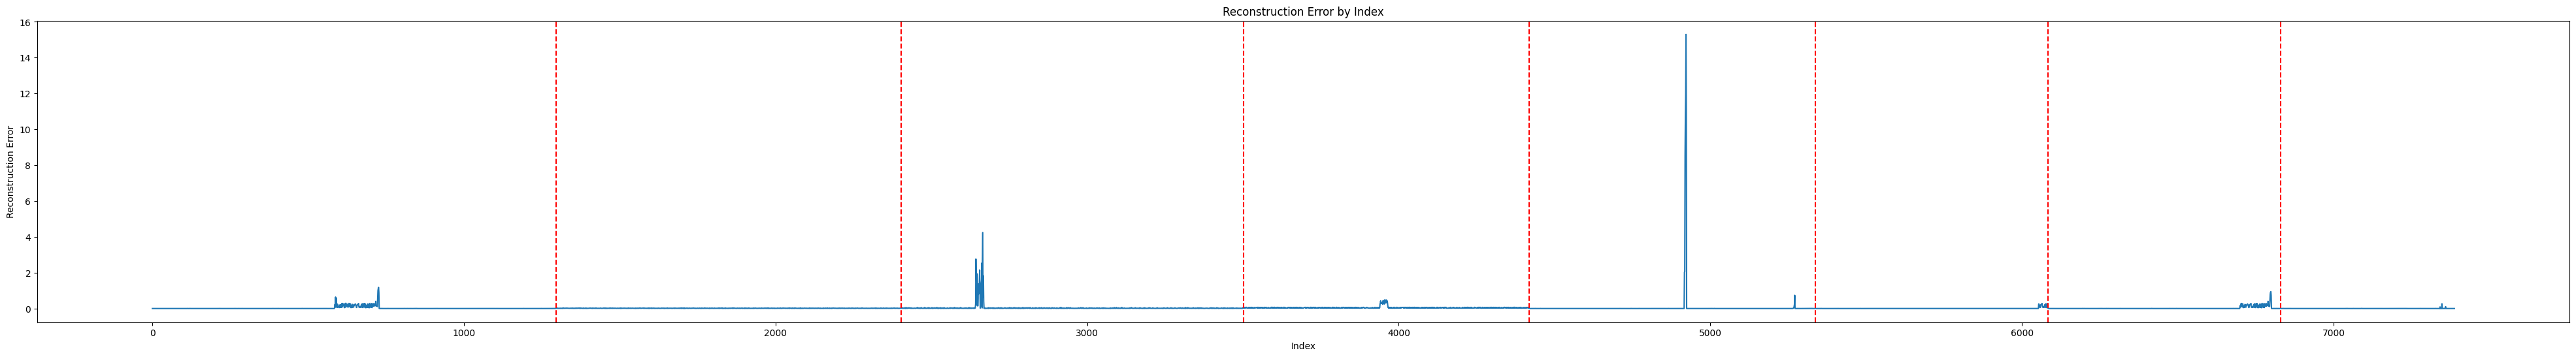

In [146]:
# 인덱스별 reconstruction_error 값을 그래프로 그립니다.
plt.figure(figsize=(50,6))
plt.plot(range(len(reconstruction_error)), reconstruction_error.detach().numpy())
# plt.axhline(y=threshold, color='r')
plt.axvline(x=1296, color='r', linestyle='--')
plt.axvline(x=2403, color='r', linestyle='--')
plt.axvline(x=3501, color='r', linestyle='--')
plt.axvline(x=4419, color='r', linestyle='--')
plt.axvline(x=5337, color='r', linestyle='--')
plt.axvline(x=6084, color='r', linestyle='--')
plt.axvline(x=6831, color='r', linestyle='--')
plt.title("Reconstruction Error by Index")
plt.xlabel("Index")
plt.ylabel("Reconstruction Error")
plt.show()

### threshold 설정

In [99]:
# Set a threshold for considering a test point as an anomaly
threshold = np.percentile(reconstruction_error.detach().numpy(), 95)

# Predict anomalies in test_data
test_predictions = (reconstruction_error.detach().numpy() > threshold).astype(int)

In [70]:
test_predictions

array([0, 0, 0, ..., 0, 0, 0])

In [71]:
from collections import Counter

count = Counter(test_predictions)
num_0 = count[0]
num_1 = count[1]

print("Number of 0s: ", num_0)
print("Number of 1s: ", num_1)

Number of 0s:  7041
Number of 1s:  348


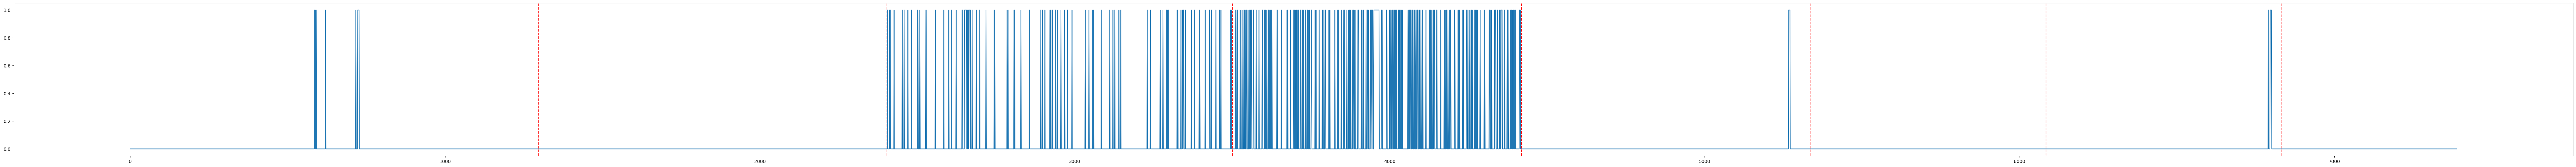

In [72]:
plt.figure(figsize=(100,6))
plt.plot(range(len(test_predictions)), test_predictions)
plt.axvline(x=1296, color='r', linestyle='--')
plt.axvline(x=2403, color='r', linestyle='--')
plt.axvline(x=3501, color='r', linestyle='--')
plt.axvline(x=4419, color='r', linestyle='--')
plt.axvline(x=5337, color='r', linestyle='--')
plt.axvline(x=6084, color='r', linestyle='--')
plt.axvline(x=6831, color='r', linestyle='--')
plt.show()

In [ ]:
file_name = 'ae_ft14_standard_no_outlier_dupl_th9536'

In [ ]:
# 코랩에 저장
idx = test_data.loc[:, 'type']
y_pred = {'type': idx, 'label': prediction2}
test_prediction = pd.DataFrame(y_pred)
test_prediction.to_csv(f"{file_name}.csv")

# Feature Importance 확인

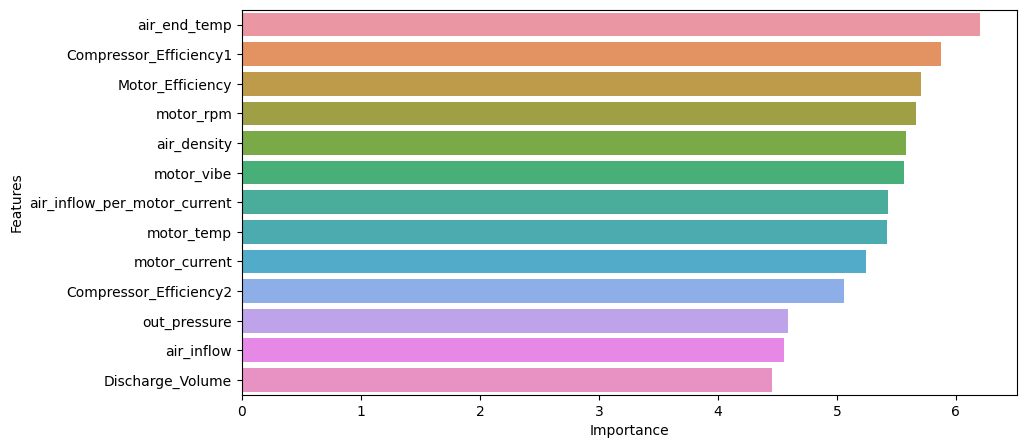

In [148]:
model.load_state_dict(torch.load(f"{model_name}.pth"))

# 가중치 추출
encoder_weights = model.encoder[0].weight.data.numpy()
decoder_weights = model.decoder[0].weight.data.numpy()

# 각 feature의 중요도 계산
importance = np.abs(np.vstack([encoder_weights, decoder_weights[:, :13]])).sum(axis=0)

# 중요도가 높은 feature 순서대로 출력
sorted_idx = np.argsort(importance)[::-1]
feature_names = df_test.columns  # 입력 데이터의 각 열에 대한 이름 리스트
sorted_feature_names = [feature_names[idx] for idx in sorted_idx]
sorted_importance = importance[sorted_idx]

# 중요도가 높은 feature 순서대로 그래프 그리기
plt.figure(figsize=(10, 5))
sns.barplot(y=sorted_feature_names, x=sorted_importance)
plt.ylabel("Features")
plt.xlabel("Importance")
plt.show()